In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [2]:
housing = pd.read_csv('./Housing.csv')
vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']
data = housing[vars]
data.head()

,area,bedrooms,bathrooms,stories,parking,price
0,7420,4,2,3,2,13300000
1,8960,4,4,4,3,12250000
2,9960,3,2,2,2,12250000
3,7500,4,2,2,3,12215000
4,7420,4,1,2,2,11410000


In [3]:
scaled = StandardScaler()
scaled_data_raw = scaled.fit_transform(data.values[:,:])
scaled_data = pd.DataFrame(scaled_data_raw)
scaled_data

,0,1,2,3,4,5
0,1.046726,1.403419,1.421812,1.378217,1.517692,4.566365
1,1.757010,1.403419,5.405809,2.532024,2.679409,4.004484
2,2.218232,0.047278,1.421812,0.224410,1.517692,4.004484
3,1.083624,1.403419,1.421812,0.224410,2.679409,3.985755
4,1.046726,1.403419,-0.570187,0.224410,1.517692,3.554979
...,...,...,...,...,...,...
540,-0.991879,-1.308863,-0.570187,-0.929397,1.517692,-1.576868
541,-1.268613,0.047278,-0.570187,-0.929397,-0.805741,-1.605149
542,-0.705921,-1.308863,-0.570187,-0.929397,-0.805741,-1.614327
543,-1.033389,0.047278,-0.570187,-0.929397,-0.805741,-1.614327


In [4]:
X = scaled_data.values[:,0:5]
Y = scaled_data.values[:,5]

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state = 0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(436, 5) (109, 5) (436,) (109,)


In [6]:
def model(area, bedrooms, bathrooms, stories, parking, w1, w2, w3, w4, w5, b):
    return w5*parking + w4*stories + w3*bathrooms + w2*bedrooms + w1*area + b
def loss_fn(t_p, price):
    squared_diffs = (t_p - price)**2
    return squared_diffs.mean()
def dloss_fn(t_p, price):
    dsq_diffs=2* (t_p - price) / t_p.size(0)
    return dsq_diffs
def dmodel_dw5(parking, w5, b):
    return parking
def dmodel_dw4(stories, w4, b):
    return stories
def dmodel_dw3(bathrooms, w3, b):
    return bathrooms
def dmodel_dw2(bedrooms, w2, b):
    return bedrooms
def dmodel_dw1(area, w1, b):
    return area
def dmodel_db(area, bedrooms, bathrooms, stories, parking, w1, w2, w3, w4, w5, b):
    return 1.0
def grad_fn(area, bedrooms, bathrooms, stories, parking, price, t_p, w1, w2, w3, w4, w5, b):
    dloss_dtp = dloss_fn(t_p, price)
    dloss_dw5 = dloss_dtp * dmodel_dw5(parking, w5, b)
    dloss_dw4 = dloss_dtp * dmodel_dw4(stories, w4, b)
    dloss_dw3 = dloss_dtp * dmodel_dw3(bathrooms, w3, b)
    dloss_dw2 = dloss_dtp * dmodel_dw2(bedrooms, w2, b)
    dloss_dw1 = dloss_dtp * dmodel_dw1(area, w1, b)
    dloss_db = dloss_dtp * dmodel_db(area, bedrooms, bathrooms, stories, parking, w1, w2, w3, w4, w5, b)
    return torch.stack([dloss_dw5.sum(),dloss_dw4.sum(),dloss_dw3.sum(),dloss_dw2.sum(), dloss_dw1.sum(), dloss_db.sum()])

In [7]:
def training_loop(n_epochs, learning_rate, params, area, bedrooms, bathrooms, stories, parking, price):
    for epoch in range(1, n_epochs + 1):
        w1, w2, w3, w4, w5, b = params
        t_p = model(area, bedrooms, bathrooms, stories, parking, w1, w2, w3, w4, w5, b)
        l = loss_fn(t_p, price)
    
        grad = grad_fn(area, bedrooms, bathrooms, stories, parking, price, t_p, w1, w2, w3, w4, w5, b)
        params = params - learning_rate * grad
    
        if epoch == 1 or epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(l)))
    return params

In [8]:
area_train = torch.tensor(X_train[:,0])
bedrooms_train = torch.tensor(X_train[:,1])
bathrooms_train = torch.tensor(X_train[:,2])
stories_train = torch.tensor(X_train[:,3])
parking_train = torch.tensor(X_train[:,4])
price_train = torch.tensor(Y_train)

w1 = torch.ones(())
w2 = torch.ones(())
w3 = torch.ones(())
w4 = torch.ones(())
w5 = torch.ones(())
b = torch.zeros(())

print("Linear Regression of the Training model's loss:")
params_train = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 0.0])
learning_rate = 1e-4
params_train = training_loop(
    n_epochs = 5000, 
    learning_rate = learning_rate, 
    params = params_train, 
    area = area_train, 
    bedrooms = bedrooms_train, 
    bathrooms = bathrooms_train, 
    stories = stories_train, 
    parking = parking_train, 
    price = price_train)
params_train

Linear Regression of the Training model's loss:
Epoch 1, Loss 5.965522
Epoch 500, Loss 4.251940
Epoch 1000, Loss 3.078354
Epoch 1500, Loss 2.277433
Epoch 2000, Loss 1.731910
Epoch 2500, Loss 1.361596
Epoch 3000, Loss 1.111678
Epoch 3500, Loss 0.944710
Epoch 4000, Loss 0.835139
Epoch 4500, Loss 0.765556
Epoch 5000, Loss 0.724139


tensor([ 0.2746,  0.4192,  0.3749,  0.1775,  0.5251, -0.0031],
       dtype=torch.float64)

In [9]:
area_test = torch.tensor(X_test[:,0])
bedrooms_test = torch.tensor(X_test[:,1])
bathrooms_test = torch.tensor(X_test[:,2])
stories_test = torch.tensor(X_test[:,3])
parking_test = torch.tensor(X_test[:,4])
price_test = torch.tensor(Y_test)

w1 = torch.ones(())
w2 = torch.ones(())
w3 = torch.ones(())
w4 = torch.ones(())
w5 = torch.ones(())
b = torch.zeros(())

print("Linear Regression of the Validation model's loss:")
params_test = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 0.0])
learning_rate = 1e-4
params_test = training_loop(
    n_epochs = 5000, 
    learning_rate = learning_rate, 
    params = params_test, 
    area = area_test, 
    bedrooms = bedrooms_test, 
    bathrooms = bathrooms_test, 
    stories = stories_test, 
    parking = parking_test, 
    price = price_test)
params_test

Linear Regression of the Validation model's loss:
Epoch 1, Loss 6.422749
Epoch 500, Loss 4.419614
Epoch 1000, Loss 3.085965
Epoch 1500, Loss 2.200358
Epoch 2000, Loss 1.612678
Epoch 2500, Loss 1.223355
Epoch 3000, Loss 0.966349
Epoch 3500, Loss 0.797858
Epoch 4000, Loss 0.688848
Epoch 4500, Loss 0.620083
Epoch 5000, Loss 0.578841


tensor([0.4858, 0.4767, 0.2127, 0.1545, 0.3222, 0.0085], dtype=torch.float64)

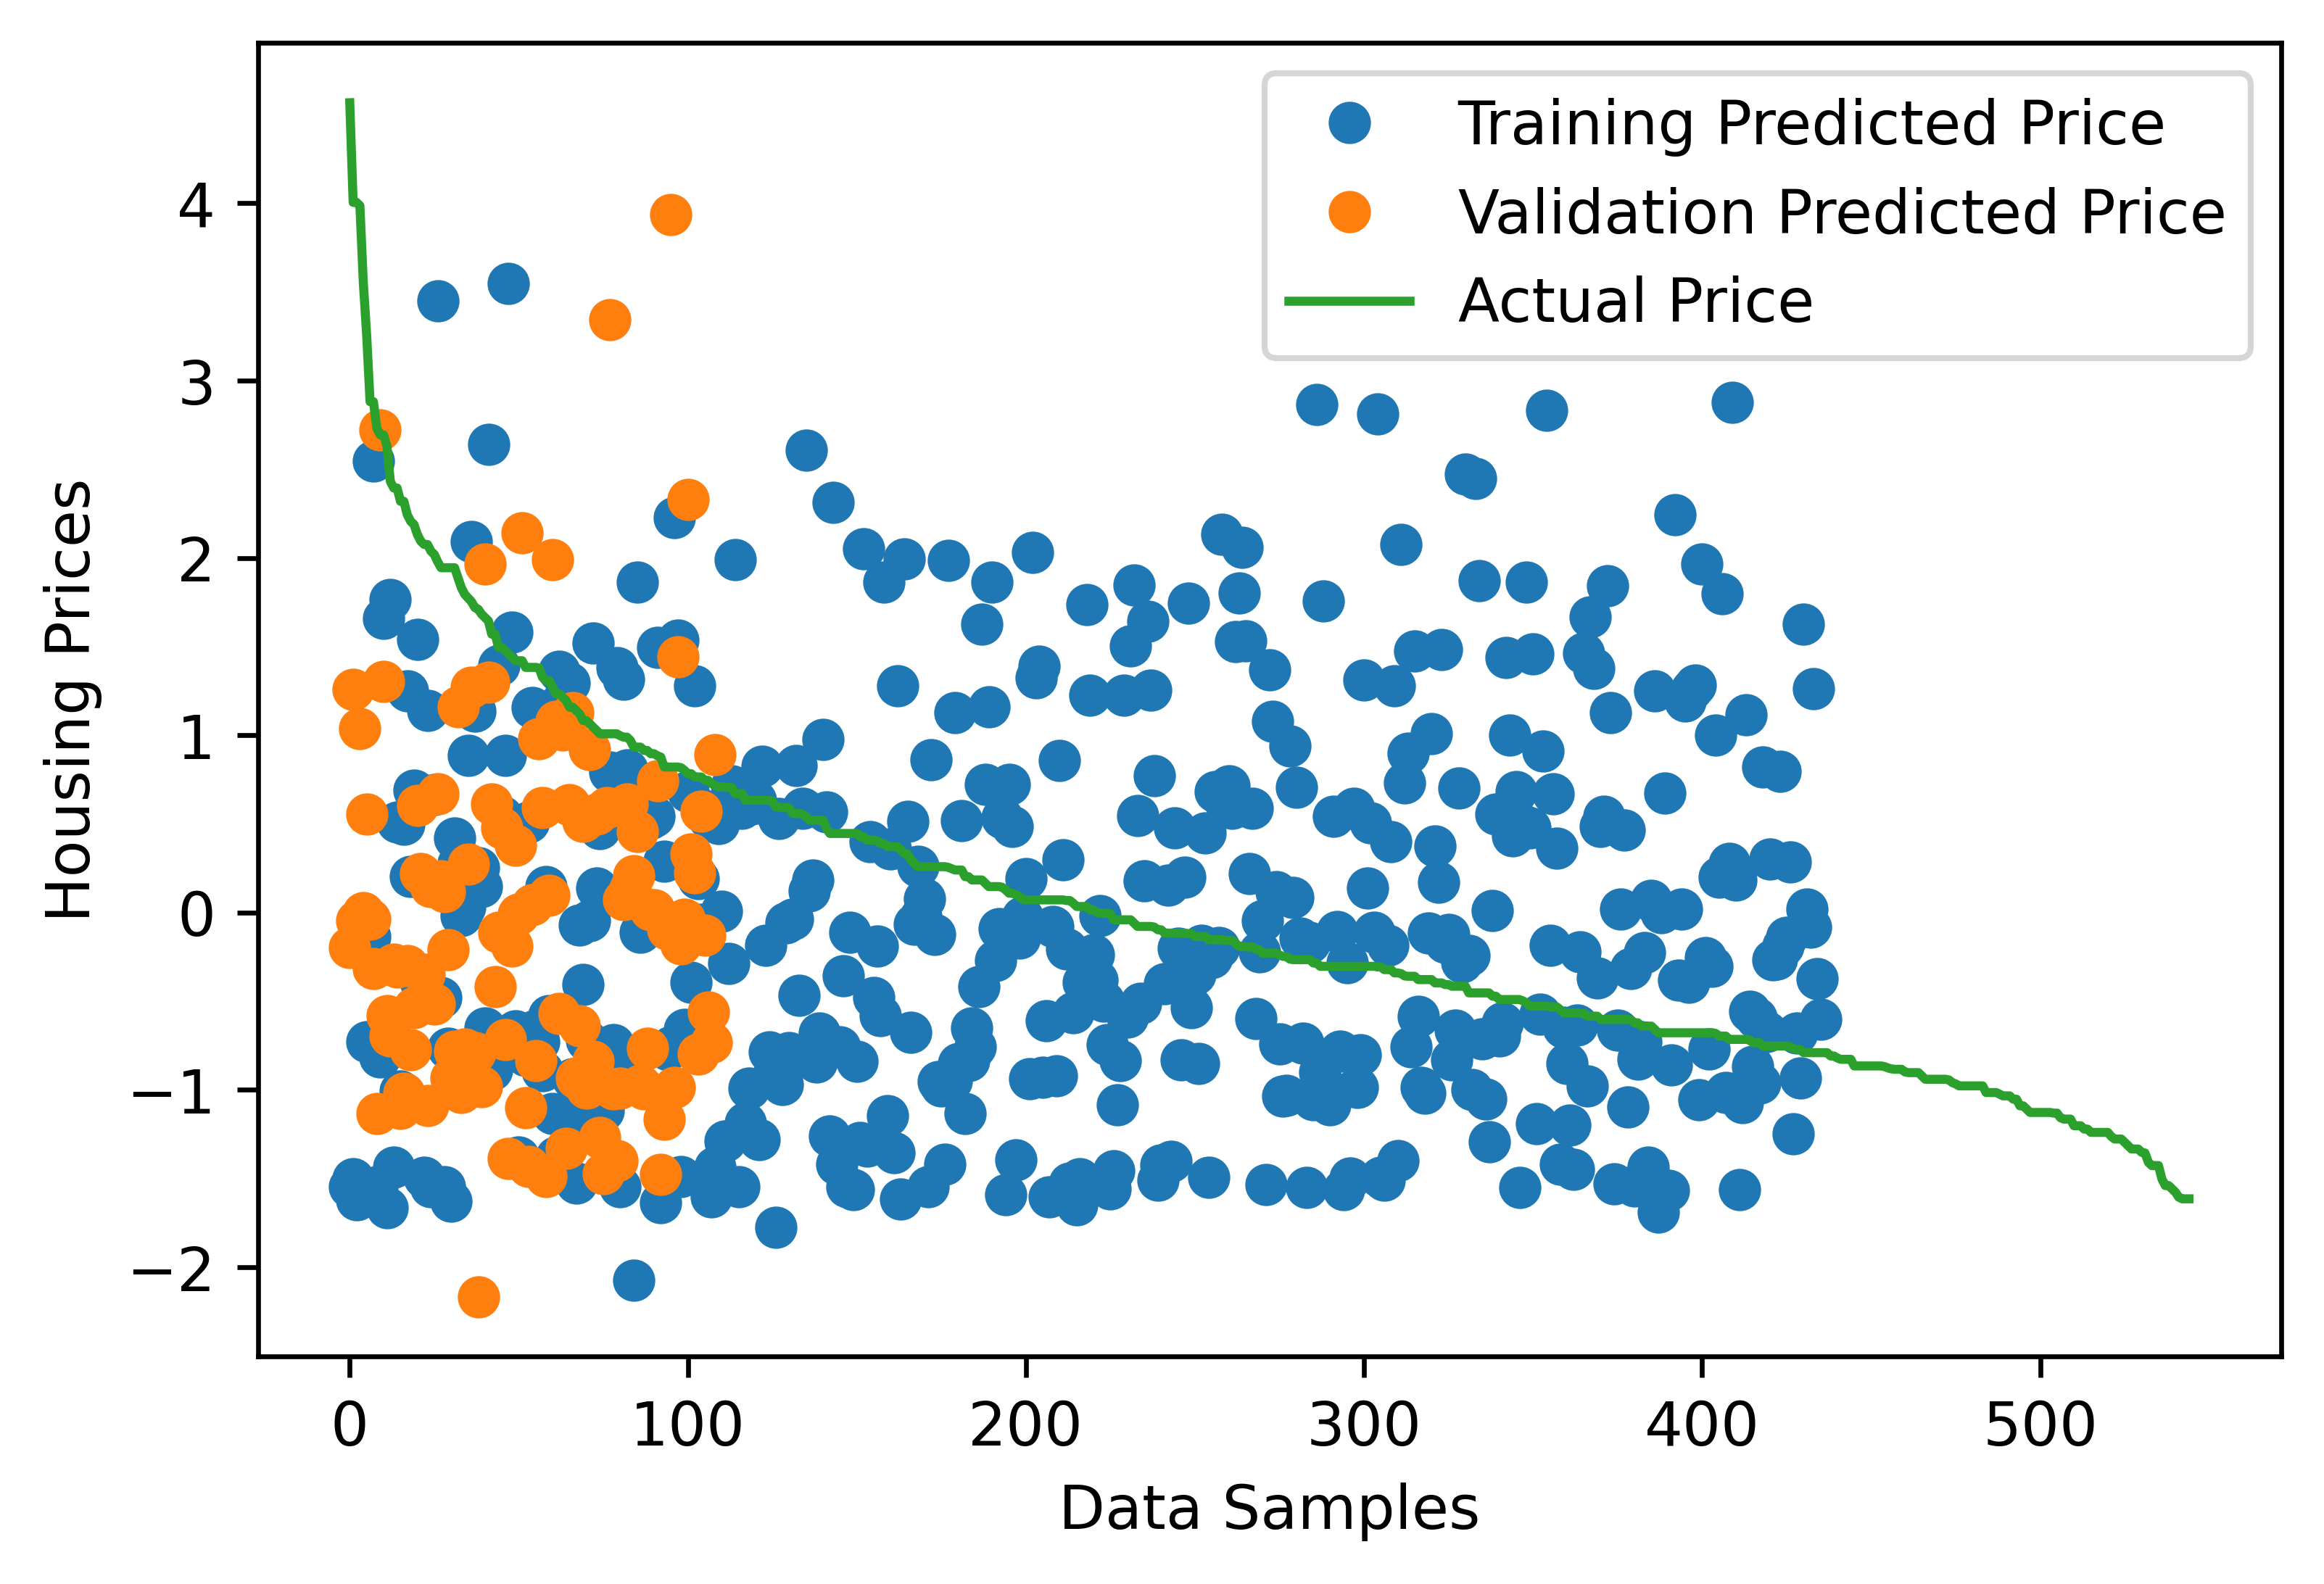

In [10]:
t_p_train = model(area_train, bedrooms_train, bathrooms_train, stories_train, parking_train, *params_train)
t_p_test = model(area_test, bedrooms_test, bathrooms_test, stories_test, parking_test, *params_test)
fig = plt.figure(dpi=600)
plt.xlabel("Data Samples")
plt.ylabel("Housing Prices")
plt.plot(t_p_train.detach().numpy(), 'o', label = "Training Predicted Price")
plt.plot(t_p_test.detach().numpy(), 'o', label = "Validation Predicted Price")
plt.plot(Y, label = 'Actual Price')
plt.legend()